# Analítica y Ciencia de Datos

## Jonnathan Cruz y Germán Villar

# Referencias:

Las propiedades y supuestos detrás del Modelo Lineal de Regresión, la pueden encontrar en [Greene, "Econometric Analysis"](http://pages.stern.nyu.edu/~wgreene/Text/econometricanalysis.htm).

También véanse los capítulos 3 y 6 de [ISL](http://www-bcf.usc.edu/~gareth/ISL/getbook.html).

O el capítulo 3 de [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

# Más regularización: Lasso


* Lasso es otro método de regularización de los coeficientes, que utiliza una métrica distinta para penalizar coeficientes grandes.

$$
\beta_{lasso} = argmin_{\beta} (y - X\beta)'(y - X\beta) + \lambda \sum_j \left \vert \beta_j \right \vert
$$

* Desde un punto de vista de optimización, este es un problema de [programación cuadrática](https://en.wikipedia.org/wiki/Quadratic_programming), i.e. uno donde la función objetivo es cuadrática y está sujeto a restricciones lineales.

    * Una alternativa es utilizar una librería de optimización cuadrática como [`cvxopt`](http://cvxopt.org/).
    * Vamos a ver otros métodos para resolver el problema de optimización que son computacionalmente eficientes.


* Así que la mala noticia es que no hay una solución analítica, como si lo había en el caso del Ridge.


* La principal diferencia entre el Lasso y el Ridge es que el segundo reduce los coeficientes, y en el límite, cuando $\lambda \rightarrow \infty$, los coeficientes son cero.


* En Lasso, parte de la solución son algunos coeficientes exactamente iguales a cero, *para cualquier valor de $\lambda$*, así que es un método que permite hacer selección de variables.


# Comparación entre Lasso y Ridge

![caption](figures/lasso_ridge.png)

Figura 6.7 de [ISLR](http://www-bcf.usc.edu/~gareth/ISL/)

# ¿Cómo se encuentra la solución de Lasso?


* Vamos a utilizar un método de optimización que se llama [coordinate descent](https://www.cs.cmu.edu/~ggordon/10725-F12/slides/25-coord-desc.pdf).


* La idea es simple: queremos minimizar 
$$
f(\beta) = g(\beta) + \sum_i h_i(\beta_i)
$$


donde $g$ es una función convexa y diferenciable, y cada una de las $h_i$ es una función convexa, no necesariamente diferenciable.


* Para encontrar el mínimo podemos hacerlo *coordenada por coordenada*.


* En el caso de Lasso, el siguiente algoritmo funciona perfectamente (ver [acá, por ejemplo](http://web.stanford.edu/~hastie/TALKS/glmnet.pdf)).

# Pseudocódigo de Lasso vía Coordinate Descent


* Estandaricemos la matriz $X$ y $y$.


* Repita lo siguiente hasta que haya convergencia, para todo $k = 1, 2, \cdots, p, 1, 2, \cdots$:

> **Paso 1**: Obtenga los residuos excluyendo el regresor $k$: 
$$    
    r_{-k} = y - x_{-k}\beta_{-k}
$$
>     donde $x_{-k}$ excluye al regresor $k$, y $\beta_{-k}$ es la versión actual de los coeficientes excluyendo al $k-$ésimo.


> **Paso 2**: Obtenga el estimador de OLS simple para el regresor $k$:
    
$$    
    \beta^*_{k} = \frac{1}{N} r_{-k}'x_k = \frac{1}{N} \sum_j r_{-k,j}x_{jk}
$$


> **Paso 3**: Actualice $\beta_k$ por medio de *soft-thresholding*

$$
\begin{eqnarray*}
\beta_k &=& signo(\beta^*_{k})(\left \vert \beta^*_{k} \right \vert -\lambda)_{+} \\
\end{eqnarray*}
$$

>  donde $(x)_{+} = max(0,x)$ denota la [parte positiva](http://mathworld.wolfram.com/PositivePart.html)

# Veamos cómo se hace en Python

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

data_cr = pd.read_csv(u'/Users/germanvillar/Documents/ecoaplicada/Credit(1).csv')
nobs    = data_cr.shape[0]
saldo    = np.asarray(data_cr.Balance).reshape((nobs,1))
male     = np.asarray(data_cr.Gender==' Male').reshape((nobs,1))
student  = np.asarray(data_cr.Student=='Yes').reshape((nobs,1))
married  = np.asarray(data_cr.Married=='Yes').reshape((nobs,1))
eth_dum  = np.asarray(pd.get_dummies(data_cr.Ethnicity))[:,:-1]
oth_xmat = data_cr[[u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education']]

labs_x = np.array([u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education',
              'Hombre','Estudiante','Casado','Caucasian','Asian'])

prexmat  = np.concatenate((oth_xmat, male, student, married, eth_dum),axis=1)
#print prexmat.shape
nvar = prexmat.shape[1]
# I will start by standardizing/normalizing the matrix
prexmat_std = prexmat.copy()
ind_dum = np.array([pd.Series(prexmat[:,k]).unique().shape[0] for k in range(nvar)])
prexmat_std[:,ind_dum>2] -= prexmat_std[:,ind_dum>2].mean(axis=0).reshape((1,6))
# get the norms
norm_pxmat = np.array([np.linalg.norm(prexmat_std[:,ind_dum>2][:,k]) for k in range(np.sum(ind_dum>2))])
# ready to normalize
prexmat_std[:,ind_dum>2] /= prexmat_std[:,ind_dum>2].std(axis=0).reshape((1,6))

# also standardize y
yy_std = saldo.copy()
yy_std -= yy_std.mean()
yy_std /= yy_std.std()

IOError: File /Users/germanvillar/Documents/ecoaplicada/Credit(1).csv does not exist

In [17]:
# Fijemos un lambda:
lambda_vec = 0.1
# Inicialicemos el vector:
beta_actual = np.zeros((1,11))
dist = 1
counter = 0
maxiter = 10000
# loop externo: si no hay convergencia continúe
while dist>0.001: 
    #or counter<maxiter:
    # Loop interno: ciclo con los regresores
    beta_old = beta_actual.copy()
    for k in range(11):
        # Residuos parciales excluyendo k
        inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
        xmat_k   = prexmat_std[:,inc_k]
        beta_k   = beta_actual[0,inc_k]
        resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
        # OLS simple de k:
        beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
        # Actualicemos beta_k
        beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
    # Actualicemos distancia:
    dist = np.max(np.abs(beta_actual-beta_old))
    counter +=1
print "total iteraciones: ", counter
pd.DataFrame(beta_actual.T, index= labs_x.flatten(), columns = ['Nuestro'])

total iteraciones:  201


,Nuestro
Income,-0.000000
Limit,0.000000
Rating,0.486001
Cards,0.000000
Age,-0.000000
Education,-0.000000
Hombre,-0.000000
Estudiante,0.000000
Casado,-0.000000
Caucasian,-0.000000


In [ ]:
# Fijemos un lambda:
lambda_vec = 0.1
# Inicialicemos el vector:
beta_actual = np.zeros((1,11))
dist = 1
counter = 0
maxiter = 10000
# loop externo: si no hay convergencia continúe
while dist>0.001: 
    #or counter<maxiter:
    # Loop interno: ciclo con los regresores
    beta_old = beta_actual.copy()
    for k in range(11):
        # Residuos parciales excluyendo k
        inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
        xmat_k   = prexmat_std[:,inc_k]
        beta_k   = beta_actual[0,inc_k]
        resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
        # OLS simple de k:
        beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
        # Actualicemos beta_k
        beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
    # Actualicemos distancia:
    dist = np.max(np.abs(beta_actual-beta_old))
    counter +=1
print "total iteraciones: ", counter
pd.DataFrame(beta_actual.T, index= labs_x.flatten(), columns = ['Nuestro'])

# Cómo se haría en Scikit-learn?

In [18]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(prexmat_std,yy_std)
pd.DataFrame(clf.coef_, index = labs_x, columns=['Scikit-Learn'])

,Scikit-Learn
Income,-0.000000
Limit,0.000000
Rating,0.486001
Cards,0.000000
Age,-0.000000
Education,-0.000000
Hombre,-0.000000
Estudiante,0.000000
Casado,-0.000000
Caucasian,-0.000000


In [52]:
# Miremos todo el path de lasso
L = 100
lambda_grid = np.linspace(0,0.6,L)
BetaLasso  = np.zeros((L,11))
for lamb in range(L):
    lambda_vec = lambda_grid[lamb]
    # Inicialicemos el vector:
    beta_actual = np.zeros((1,11))
    dist = 1
    counter = 0
    maxiter = 10000
    # loop externo: si no hay convergencia continúe
    while dist>0.001: 
        #or counter<maxiter:
        # Loop interno: ciclo con los regresores
        beta_old = beta_actual.copy()
        for k in range(11):
            # Residuos parciales excluyendo k
            inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
            xmat_k   = prexmat_std[:,inc_k]
            beta_k   = beta_actual[0,inc_k]
            resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
            # OLS simple de k:
            beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
            # Actualicemos beta_k
            beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
        # Actualicemos distancia:
        dist = np.max(np.abs(beta_actual-beta_old))
        counter +=1
    # terminó, podemos actualizar
    BetaLasso[lamb,:] = beta_actual.reshape((1,11))

In [ ]:
# Miremos todo el path de lasso
L = 100
lambda_grid = np.linspace(0,0.6,L)
BetaLasso  = np.zeros((L,11))
for lamb in range(L):
    lambda_vec = lambda_grid[lamb]
    # Inicialicemos el vector:
    beta_actual = np.zeros((1,11))
    dist = 1
    counter = 0
    maxiter = 10000
    # loop externo: si no hay convergencia continúe
    while dist>0.001: 
        #or counter<maxiter:
        # Loop interno: ciclo con los regresores
        beta_old = beta_actual.copy()
        for k in range(11):
            # Residuos parciales excluyendo k
            inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
            xmat_k   = prexmat_std[:,inc_k]
            beta_k   = beta_actual[0,inc_k]
            resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
            # OLS simple de k:
            beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
            # Actualicemos beta_k
            beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
        # Actualicemos distancia:
        dist = np.max(np.abs(beta_actual-beta_old))
        counter +=1
    # terminó, podemos actualizar
    BetaLasso[lamb,:] = beta_actual.reshape((1,11))

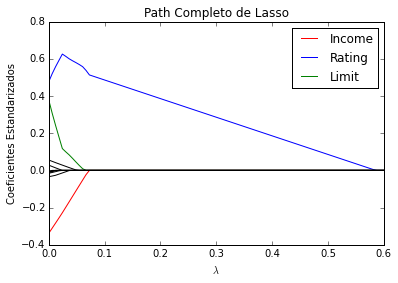

In [54]:
BetaLassoDF = pd.DataFrame(BetaLasso, columns= labs_x)
BetaLassoDF['lambda_lasso'] = lambda_grid
# Grafiquemos:
plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF.Income, label='Income', color='r')
plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF.Rating, label='Rating', color='b')
plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF.Limit,  label='Limit', color='g')
labs_exc = np.array([u'Cards', u'Age', u'Education',
              'Hombre','Estudiante','Casado','Caucasian','Asian'])
for k in range(8):
    plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF[labs_exc[k]], color='k')
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('Coeficientes Estandarizados')
plt.title('Path Completo de Lasso')

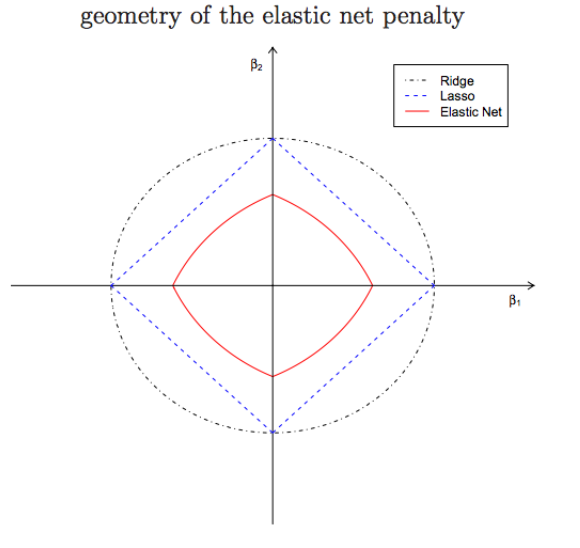

In [1]:
from IPython.display import Image
Image(filename='pic1-enet.png')